# A/B Testing Python Practice 

**A/B testing is a common testing framework used to see if two versions of a scenario lead to different outcomes and to see which one is better.**

This practice will use a [Kaggle dataset](https://www.kaggle.com/zhangluyuan/ab-testing) of a A/B test results from comparing two different designs of the web page.

## A/B test process
1. Develop a hypothesis about your product or business
2. Randomly assign user to two different groups
3. Expose:
- Group 1 to the current product role
- Group 2 to a product that tests the hypothesis
4. Pick the better one


### Scenario
The company deploys a new version of the website page in order to increase the conversion rate. Before rolling out the new version, we will run an A/B test on a small number of users to see how it performs.

#### 1. Develop a hypothesis about the conversion rate
We want to test whether we have different average conversion rate per user in our two versions of web page. In this case, we use a proportions test. 

The appropriate statistical test here is a proportions z-test. 

Assuming $p_A$ is the conversion rate for the old page and $p_B$ is the conversion rate for new page, we want to test if:
$$ d = p_A - p_B $$

When we take differences of conversion rates, $d$ is normally distributed. This allows us to set up the following hypothesis test:

$$ H_0 : d = 0 \; \; \; \text{vs}\; \; \; H_1 : d \neq 0 $$


To perform a hypothesis test, we

* Assume the null is true
* Look at the sample of data and see how different it is from our assumption
* Make a decision about whether our initial assumption was wrong

#### 2. Randomly assign user to two different groups
- **Control group** - they will be landing on the old page
- **Treatment group** - they will be landing on the new page

#### 3. EDA and Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read the data from csv into dataframe
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
print(f'We have {df.shape[0]} rows and {df.shape[1]} columns for data')

We have 294478 rows and 5 columns for data


In [4]:
# check the null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
# Check if all users landing the page they should
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In the dataset, there are some data contains users landing on the wrong page, let's clean that up.

In [6]:
df = df.drop(df[(df['group']=='treatment') & (df['landing_page']=='old_page')].index)
df = df.drop(df[(df['group']=='control') & (df['landing_page']=='new_page')].index)

In [7]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [8]:
df.shape

(290585, 5)

In [9]:
# check again
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [10]:
# check if we still have any duplicated user_id 
df[df['user_id'].duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [11]:
# drop duplicated user records
df = df.drop_duplicates(subset=['user_id'], keep = 'last')

In [12]:
print(f'We now have {df.shape[0]} rows and {df.shape[1]} columns for data')

We now have 290584 rows and 5 columns for data


#### 4. Sampling

In [13]:
# see how many users in each group
df.groupby('group').count()['converted']

group
control      145274
treatment    145310
Name: converted, dtype: int64

The number of users from two group are not equal, we will take sample from each group.

In [14]:
import math
import statsmodels.stats.api as sms

Let's say the current conversion rate is 0.12, and we want to increase the conversion rate to 0.13 by 10%, the sample size of the test group and the control group is the same. We set up significance level = 5% and Power = 80%.

In [15]:
effect_size = sms.proportion_effectsize(0.11, 0.12)
n = sms.NormalIndPower().solve_power(
    effect_size=effect_size,
    nobs1=None,
    alpha=0.05,
    power=0.8,
    ratio=1.0,
    alternative='two-sided')
print(n)

15969.328371020014


To get the result we want, we need at least 15970 users from each group to run the hypothesis test.

In [16]:
n = 15970

In [17]:
control_sample = df[df['group'] == 'control'].sample(n = n, random_state = 1)
treatment_sample = df[df['group'] == 'treatment'].sample(n = n, random_state = 1)
df_test = pd.concat([control_sample, treatment_sample])

As a first attempt, let's look at the average number of potential users who converted in each group:

Conversion rate of group control: 

In [18]:
# Total users of two groups 
df_test.groupby('group').count()['converted']

group
control      15970
treatment    15970
Name: converted, dtype: int64

Conversion rate of group treatment:

In [19]:
# converted users of two groups
df_test.groupby('group').sum()['converted']

group
control      1924
treatment    1906
Name: converted, dtype: int64

In [20]:
# Conversion rate of group control
df_test[df_test['group']=='control']['converted'].mean()*100

12.047589229805885

In [21]:
# Conversion rate of group treatment
df_test[df_test['group']=='treatment']['converted'].mean()*100

11.934877896055102

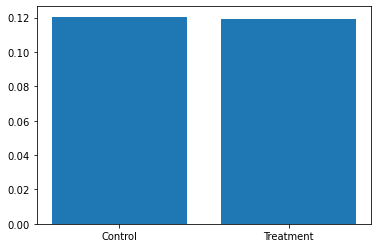

In [22]:
# Visualize the results 
plt.figure()
plt.bar(['Control', 'Treatment'], [0.1205, 0.1193])
plt.show()

The above chart showing that the average conversion rates of two group are very close, and the conversion rate drop a bit for the new web page.

#### 5. Running the hypothesis test

In [23]:
# proportions z test is located inside statsmodels
from statsmodels.stats.proportion import proportions_ztest

In [24]:
# Getting a statistic and p-value for the hypothesis test using the data above

# these are the counts of coverted user in group control and group treatment
counts = [1924, 1906]
# these are the counts of selected user in group control and group treatment
nobs = [15970, 15970]

# test
proportions_ztest(counts,nobs)

(0.31003459087599405, 0.7565346517716275)

#### 6. Conclusion

The p-value is ~0.76 which means we cannot reject the null hypothesis. Therefore, we cannot say there is a statistical difference between our two samples and we can't conclude the different versions led to different conversion rate.